In [ ]:
# Mounting the drive to load the data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/NLP assignment3/'

/content/drive/MyDrive/NLP assignment3


In [ ]:
import pandas as pd

# Update the path if needed
df = pd.read_csv('/content/drive/MyDrive/NLP assignment3/fomc_transcripts_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Content'])


In [ ]:
!pip install transformers
!pip install -U spacy
!pip install wordcloud

In [ ]:
# Import libraries
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

In [ ]:
# Preview the dataset
print(df.columns)
df.head()

Index(['URL', 'Date', 'Year', 'Month', 'Day', 'Source', 'Content',
       'cleaned_text'],
      dtype='object')


,URL,Date,Year,Month,Day,Source,Content,cleaned_text
0,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
1,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
2,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,2025,3,19,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...
3,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,Please enable JavaScript if it is disabled in ...,please enable javascript if it is disabled in ...
4,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,2025,1,29,Main Calendar,HomeMonetary PolicyFederal Open Market Committ...,homemonetary policyfederal open market committ...


In [ ]:
# Load the FinBERT model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "yiyanghkust/finbert-tone"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to chunk cleaned_text into sentence groups
def chunk_text(text, chunk_size=5):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    return [' '.join(sentences[i:i+chunk_size]) for i in range(0, len(sentences), chunk_size)]

# Apply chunking to your cleaned_text column
df['chunks'] = df['cleaned_text'].apply(lambda x: chunk_text(str(x), chunk_size=5))

# Explode chunks into rows and preserve meeting Date
df_chunks = df.explode('chunks').dropna(subset=['chunks']).reset_index(drop=True)

# Rename for clarity
df_chunks = df_chunks.rename(columns={'chunks': 'chunk_text'})
df_chunks[['Date', 'chunk_text']].head()


,Date,chunk_text
0,2025-03-19,homemonetary policyfederal open market committ...
1,2025-03-19,homemonetary policyfederal open market committ...
2,2025-03-19,â .. â .. â .. â .. â .. â .. â .. â .december...
3,2025-03-19,â .december projection ..... â .. â .. â .. â ...
4,2025-03-19,â .. â .. â .. â .. â .. â .december projectio...


In [ ]:
from transformers import pipeline
from tqdm.notebook import tqdm

# Setup FinBERT pipeline
model_name = "yiyanghkust/finbert-tone"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name, truncation=True, max_length=512)

# Apply FinBERT to each chunk
tqdm.pandas()  # show progress bar

# Predict sentiment for each chunk
df_chunks['finbert_result'] = df_chunks['chunk_text'].progress_apply(lambda x: sentiment_pipeline(x)[0])

# Extract label and score
df_chunks['finbert_label'] = df_chunks['finbert_result'].apply(lambda x: x['label'])
df_chunks['finbert_score'] = df_chunks['finbert_result'].apply(lambda x: x['score'])

# Preview result
df_chunks[['Date', 'chunk_text', 'finbert_label', 'finbert_score']].head()

Device set to use cpu


  0%|          | 0/3842 [00:00<?, ?it/s]

,Date,chunk_text,finbert_label,finbert_score
0,2025-03-19,homemonetary policyfederal open market committ...,Neutral,0.999931
1,2025-03-19,homemonetary policyfederal open market committ...,Neutral,0.999999
2,2025-03-19,â .. â .. â .. â .. â .. â .. â .. â .december...,Neutral,0.999993
3,2025-03-19,â .december projection ..... â .. â .. â .. â ...,Neutral,0.999998
4,2025-03-19,â .. â .. â .. â .. â .. â .december projectio...,Neutral,0.999997


In [ ]:
import plotly.graph_objects as go

# Ensure YearMonth is a string for better x-axis labels
sentiment_over_time.index = sentiment_over_time.index.astype(str)

# Create the figure
fig = go.Figure()

# Add a line for each sentiment
for sentiment in sentiment_over_time.columns:
    fig.add_trace(go.Scatter(
        x=sentiment_over_time.index,
        y=sentiment_over_time[sentiment],
        mode='lines+markers',
        name=sentiment
    ))

# Update layout
fig.update_layout(
    title="Sentiment Trends Over Time (FinBERT)",
    xaxis_title="Date (Year-Month)",
    yaxis_title="Number of Chunks",
    hovermode="x unified",
    template="plotly_white",
    legend_title="Sentiment",
    height=500,
    width=1000
)

fig.show()


In [ ]:
# Ensure all labels are uppercase and clean
df_chunks['finbert_label'] = df_chunks['finbert_label'].str.upper().str.strip()


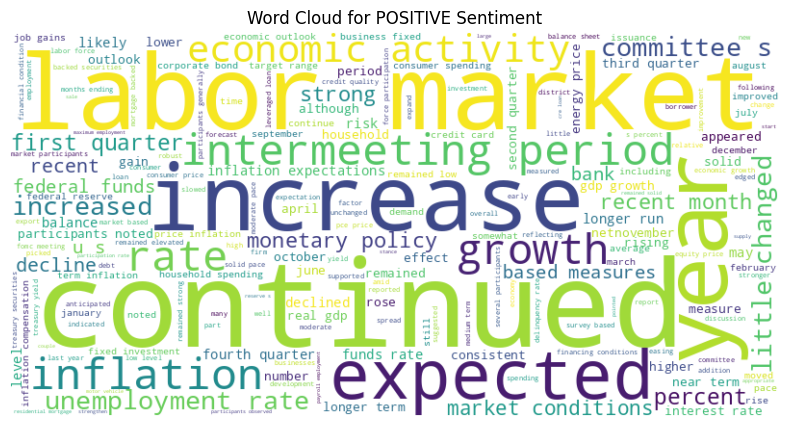

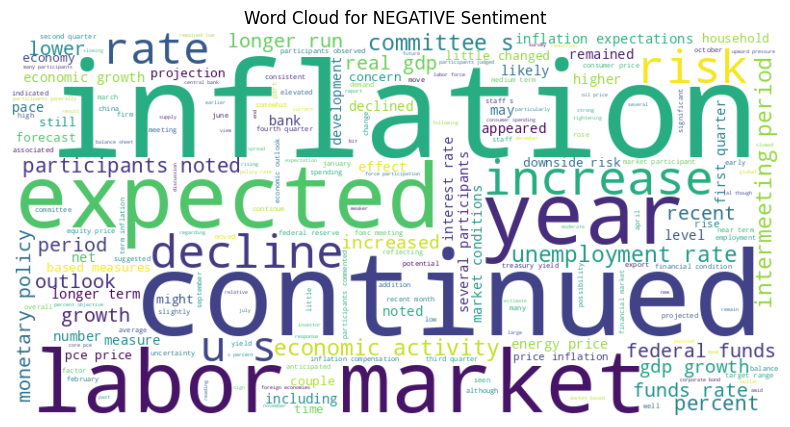

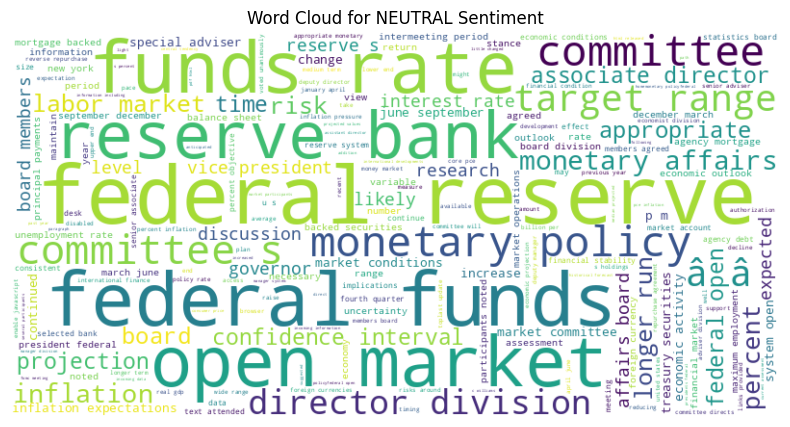

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud per sentiment
for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
    sentiment_texts = df_chunks[df_chunks['finbert_label'] == sentiment]['chunk_text']
    full_text = " ".join(sentiment_texts.dropna().astype(str))

    if full_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {sentiment} Sentiment")
        plt.show()
    else:
        print(f"No text found for {sentiment} sentiment. Skipping word cloud generation.")


In [ ]:
import plotly.express as px

# Create grouped bar chart with Plotly
fig = px.histogram(
    df_chunks,
    x='noise_type',
    color='finbert_label',
    barmode='group',
    title='FinBERT Sentiment Distribution by Noise Type',
    labels={'noise_type': 'Noise Type', 'finbert_label': 'Sentiment'},
    height=400,
    width=800,
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Chunk Noise Category',
    yaxis_title='Count',
    legend_title='Sentiment',
    bargap=0.2
)

fig.show()

In [ ]:
import plotly.express as px

# Convert boolean to integer for plotting
sentiment_shift['shift'] = sentiment_shift['changed'].astype(int)

fig = px.line(
    sentiment_shift,
    x='Date',
    y='shift',
    title='Sentiment Shifts Between FOMC Meetings (FinBERT)',
    markers=True,
    labels={'shift': 'Sentiment Changed (0 = No, 1 = Yes)'},
    height=450
)

fig.update_traces(line=dict(color='crimson'))
fig.update_layout(
    yaxis=dict(tickvals=[0, 1], ticktext=['No', 'Yes']),
    template='plotly_white',
    xaxis_title="Meeting Date",
    yaxis_title="Sentiment Shift",
    hovermode="x unified"
)

fig.show()


In [ ]:
import plotly.express as px

# Convert to datetime and group by Year-Month
df_chunks['Date'] = pd.to_datetime(df_chunks['Date'])
df_chunks['YearMonth'] = df_chunks['Date'].dt.to_period('M').astype(str)

# Group and calculate average confidence
avg_conf = df_chunks.groupby('YearMonth')['finbert_score'].mean().reset_index()

# Create interactive bar chart
fig = px.bar(
    avg_conf,
    x='YearMonth',
    y='finbert_score',
    title='Average FinBERT Confidence Over Time',
    labels={'YearMonth': 'Year-Month', 'finbert_score': 'Average Confidence Score'},
    height=450
)

fig.update_layout(
    template='plotly_white',
    xaxis_tickangle=-45,
    xaxis_title="Date (Year-Month)",
    yaxis_title="Average Confidence Score",
    hovermode="x unified"
)

fig.show()


In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def get_top_words(text_series):
    words = " ".join(text_series).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 3]
    return Counter(words).most_common(15)

for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
    top_words = get_top_words(df_chunks[df_chunks['finbert_label'] == sentiment]['chunk_text'])
    print(f"\nTop words for {sentiment} sentiment:")
    for word, count in top_words:
        print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Top words for POSITIVE sentiment:
inflation: 1073
market: 907
remained: 875
participants: 835
economic: 789
rate: 782
continued: 707
labor: 652
quarter: 635
growth: 581
recent: 521
conditions: 518
percent: 512
credit: 478
year: 451

Top words for NEGATIVE sentiment:
inflation: 1828
participants: 1628
economic: 1092
market: 1081
rate: 1063
growth: 936
prices: 763
continued: 752
remained: 748
labor: 732
policy: 711
would: 604
financial: 599
percent: 588
year: 583

Top words for NEUTRAL sentiment:
federal: 3681
committee: 3292
inflation: 2531
rate: 2464
market: 2380
board: 2208
policy: 2194
reserve: 2049
monetary: 1843
participants: 1803
division: 1696
would: 1613
economic: 1531
funds: 1525
percent: 1490


In [ ]:
# Convert date column to datetime
df_chunks['Date'] = pd.to_datetime(df_chunks['Date'])

# For each date, get the most common sentiment (mode)
daily_sentiment = df_chunks.groupby('Date')['finbert_label'].agg(lambda x: x.mode()[0]).reset_index()

# Add previous day's sentiment
daily_sentiment['prev_sentiment'] = daily_sentiment['finbert_label'].shift(1)

# Flag where sentiment changed
daily_sentiment['sentiment_changed'] = daily_sentiment['finbert_label'] != daily_sentiment['prev_sentiment']

# View result
daily_sentiment.head()


,Date,finbert_label,prev_sentiment,sentiment_changed
0,2015-01-28,NEUTRAL,None,True
1,2015-03-18,NEUTRAL,NEUTRAL,False
2,2015-04-29,NEGATIVE,NEUTRAL,True
3,2015-06-17,NEGATIVE,NEGATIVE,False
4,2015-07-29,NEUTRAL,NEGATIVE,True
